Load the importance score track and the motifs

In [1]:
from __future__ import division, print_function
%matplotlib inline
from deeplift.visualization import viz_sequence
import numpy as np
dl_contribs_track = np.load("deeplift_contribs_AP1_binding_site.npy")
onehot_track = np.load("onehot_track_AP1_binding_site.npy")
#sum the deeplift contribs across all 4 bases,
#then multiply by the one-hot track, for ease of visualization
track_to_score = np.sum(dl_contribs_track,axis=1)[:,None]*onehot_track
motifs = np.load("homer_pwms_344.npy")

#convert the motifs to log-odds space
def log_odds_space(pwm, background,pseudocount):
    new_pwm = []
    for pos_values in np.transpose(pwm,(1,0)):
        if sum(pos_values)==0:
            new_pwm.append(pos_values)
        else:
            pos_values = pos_values+pseudocount/(1+pseudocount*4)
            new_pwm.append(np.log(pos_values) - np.log(background))
    return np.array(new_pwm).transpose(1,0)

log_odds_motifs = np.array([log_odds_space(pwm=x, background=np.array([0.25, 0.25, 0.25, 0.25]),
                                          pseudocount=0.001) for x in motifs]).astype("float32")

#normalize to unit magnitude for projection
normalized_log_odds_motifs = log_odds_motifs/(np.linalg.norm(np.reshape(log_odds_motifs,(log_odds_motifs.shape[0],-1)),axis=1))[:,None,None]

There are 344 motifs of length 24. Motifs that were shorter than 24 positions were zero-padded to reach 24 positions in order to create this matrix.

In [2]:
print(motifs.shape)

(344, 4, 24)


Visualize the sequence which is 145bp long

(145, 4)


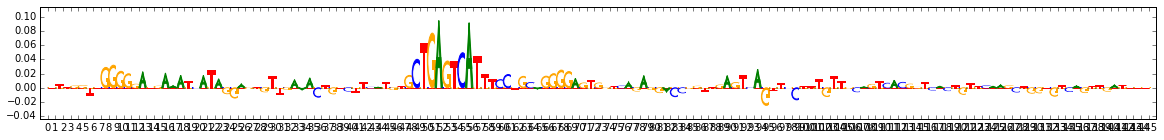

In [3]:
print(track_to_score.shape)
viz_sequence.plot_weights(track_to_score)

We compare two different scoring methods. `scan_regions_with_filters` takes the cross-correlation of the score track with the PWMs; when the PWMs are normalized to have unit magnitude, this is effectively a projection of the scores onto each PWM at every sliding window. `project_onto_nonzero_filters` is more sophisticated; it is also taking a projection, but rather than projecting onto the original PWMs, it zeros out all bases in the PWM that are absent from the underlying sequence of the sliding window. So, for example, if the sliding window is overlooking the sequence `TGAGTCA`, the first approach will take the projections onto each original PWM, while the second approach will zero out all values in each PWM that do not correspond to TGAGTCA (that is, it will zero out A,C & G for the first position, A, C & T for the second position, etc.), and THEN take the projection onto the resulting zero'd-out matrix. 

Here is an example of the zero-ing out approach:

Before zero'ing out, the PWM looks like this:
```
array([[ 0.054     ,  0.023     ,  0.033     ,  0.88999999],
       [ 0.029     ,  0.062     ,  0.77499998,  0.134     ],
       [ 0.78799999,  0.037     ,  0.038     ,  0.13699999],
       [ 0.092     ,  0.40200001,  0.43700001,  0.069     ],
       [ 0.073     ,  0.075     ,  0.073     ,  0.77899998],
       [ 0.13600001,  0.73799998,  0.093     ,  0.033     ],
       [ 0.884     ,  0.031     ,  0.029     ,  0.056     ]], dtype=float32)
```
After zero'ing out for a window with sequence TGAGTCA, the same PWM looks like this (column order is ACGT):
```
array([[ 0.000     ,  0.000     ,  0.000     ,  0.88999999],
       [ 0.000     ,  0.000     ,  0.77499998,  0.000     ],
       [ 0.78799999,  0.000     ,  0.000     ,  0.000     ],
       [ 0.000     ,  0.000     ,  0.43700001,  0.000     ],
       [ 0.000     ,  0.000     ,  0.000     ,  0.77899998],
       [ 0.000     ,  0.73799998,  0.000     ,  0.000     ],
       [ 0.884     ,  0.000     ,  0.000     ,  0.000     ]], dtype=float32)
```
Naturally, the zero'ing out is specific to the sequence underlying each sliding window. It turns out that this can be computed easily with a combination of convolutions and basic arithmetic operations (see code for details)

In [4]:
from modisco import util
simple_projection_scores = util.scan_regions_with_filters(filters=normalized_log_odds_motifs,
                                                          regions_to_scan=np.array(track_to_score.transpose(1,0)[None,None,:,:]))
nonzero_projection_scores = util.project_onto_nonzero_filters(filters=log_odds_motifs, track=np.array([track_to_score]))


WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29



Done 0
Done 0


Using gpu device 0: GeForce GT 750M (CNMeM is disabled, cuDNN 5005)


The returned matrices have 4 dimensions. The first dimension is the example index; there is only one example here, so it has size 1. The second dimension is the motif index, so it has size 344. The third dimension determines whether you are looking at the scores (index 0), or looking at whether or not the top match was with the forward or reverse version of the motif (index 1; more on this later). The fourth dimension is the position along the sequence. There are 122 length-wise positions in the score matrix because 145 was the original length of the sequence and the motifs were of size 24, and you can fit 122 sliding-window scans of a window of size 24 in a region of length 145 (145-24+1 = 122).

In [5]:
print(simple_projection_scores.shape)
print(nonzero_projection_scores.shape)

(1, 344, 2, 122)
(1, 344, 2, 122)


Take the maximum score across the length of the sequence for each motif. Note that we take index 0 in the third dimension becasue we are interested in the scores, not whether or not the match was to the forward or reverse complement motif.

In [6]:
max_simple_projection_scores = np.max(simple_projection_scores[0,:,0,:],axis=-1)
max_nonzero_projection_scores = np.max(nonzero_projection_scores[0,:,0,:],axis=-1)

Visualize the top 10 motifs according to simple projection method. Note that the motif at rank 5 using the simple projection does not look much like TGA-TCA

Simple projection
rank: 0 motif: 33


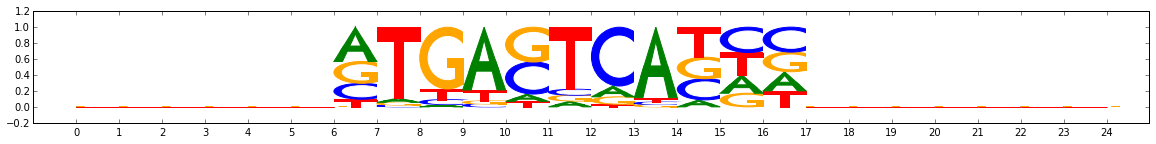

rank: 1 motif: 299


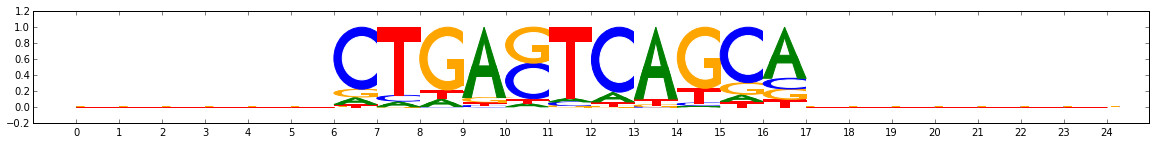

rank: 2 motif: 198


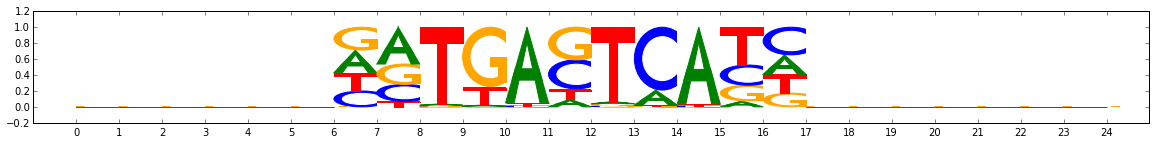

rank: 3 motif: 30


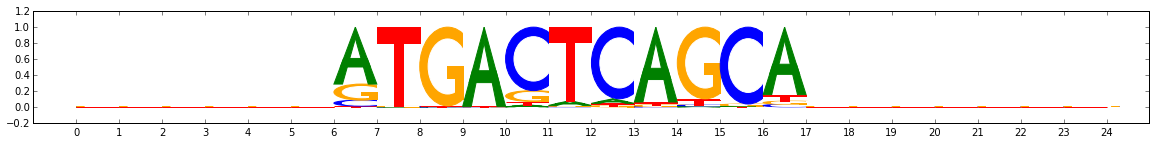

rank: 4 motif: 32


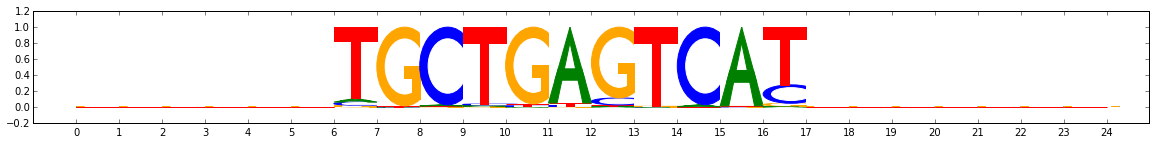

rank: 5 motif: 62


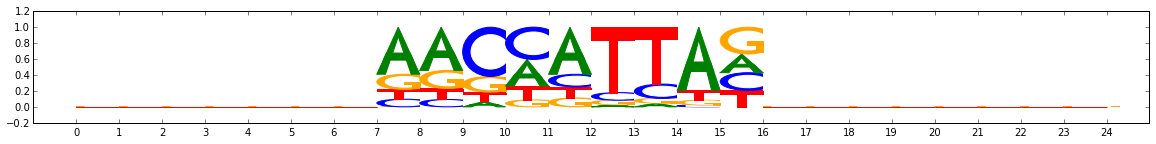

rank: 6 motif: 264


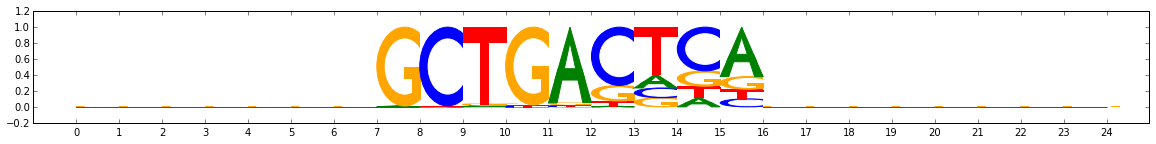

rank: 7 motif: 180


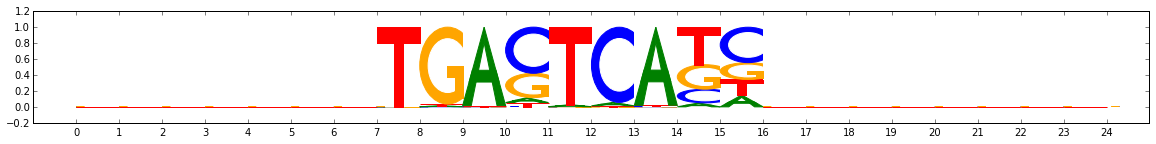

rank: 8 motif: 111


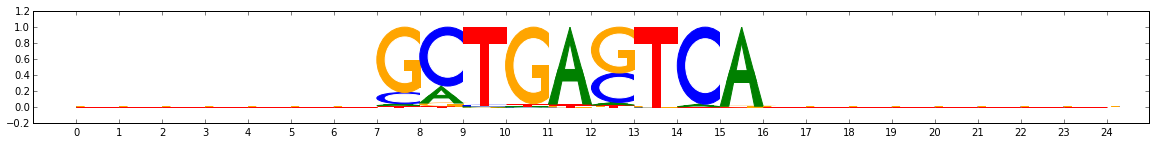

rank: 9 motif: 233


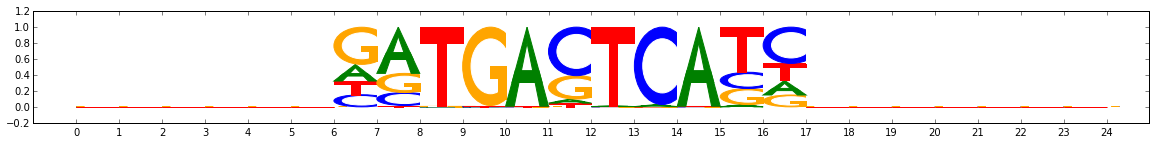

In [7]:
print("Simple projection")
for rank,(motif_index,score) in enumerate(sorted(enumerate(max_simple_projection_scores),key=lambda x: -x[1])[:10]):
    print("rank:", rank, "motif:", motif_index)
    viz_sequence.plot_weights(motifs[motif_index])

Visualize the top 10 motifs according to nonzero projection method. Note that all the motifs look like TGA-TCA

Nonzero projection
rank: 0 motif: 33


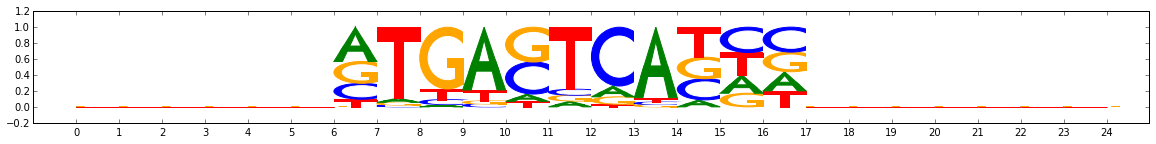

rank: 1 motif: 165


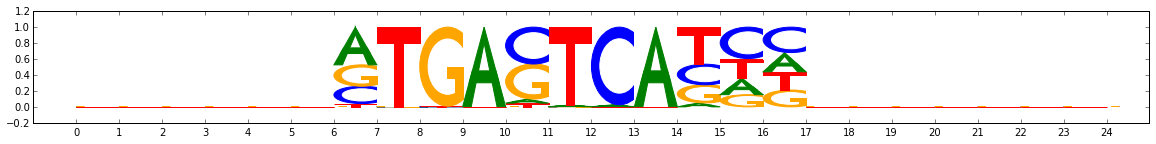

rank: 2 motif: 341


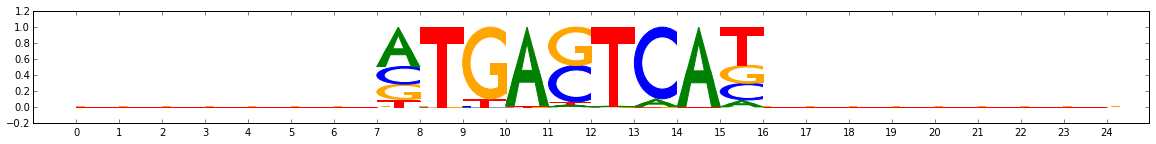

rank: 3 motif: 45


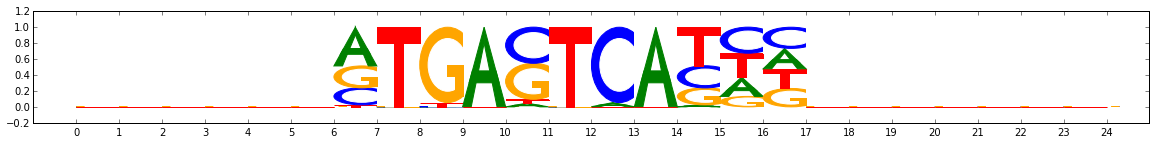

rank: 4 motif: 198


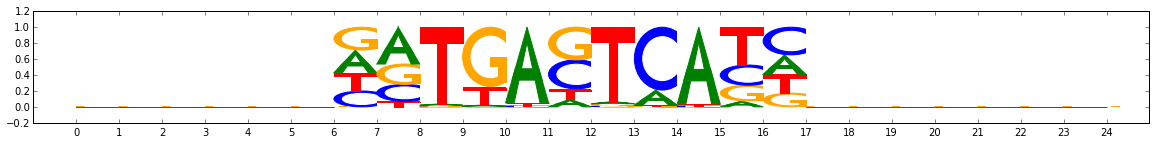

rank: 5 motif: 180


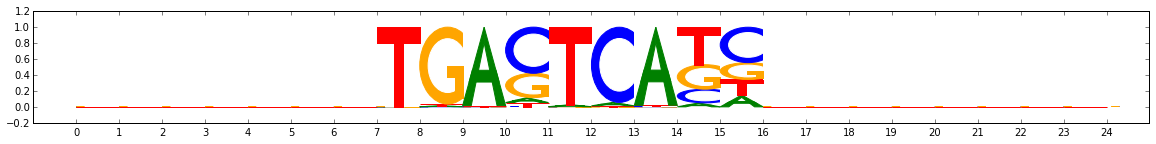

rank: 6 motif: 233


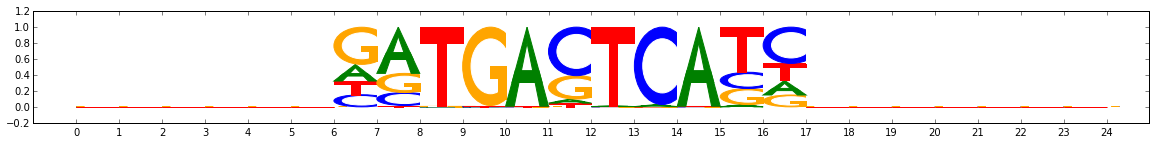

rank: 7 motif: 111


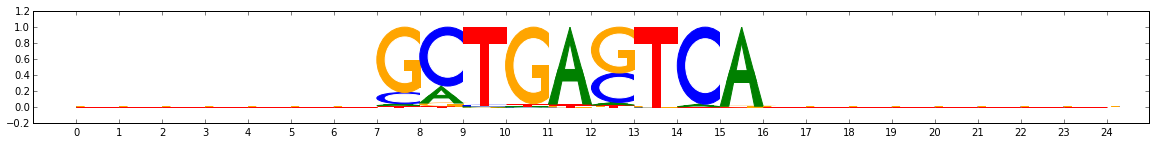

rank: 8 motif: 30


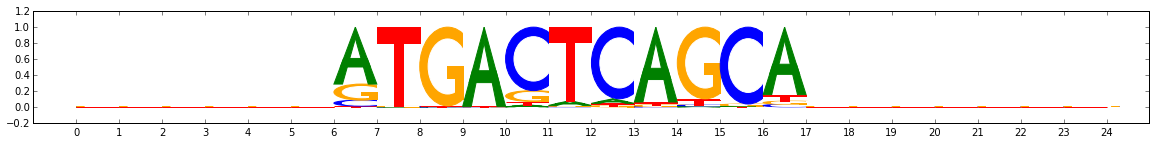

rank: 9 motif: 32


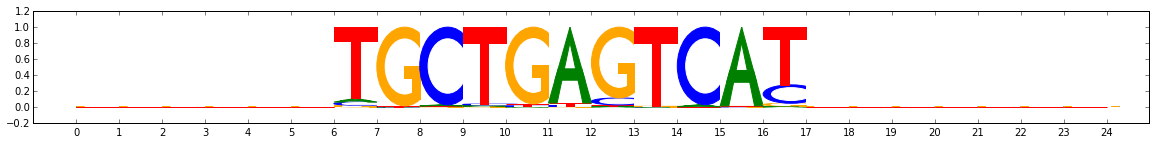

In [8]:
print("Nonzero projection")
for rank,(motif_index,score) in enumerate(sorted(enumerate(max_nonzero_projection_scores),key=lambda x: -x[1])[:10]):
    print("rank:", rank, "motif:", motif_index)
    viz_sequence.plot_weights(motifs[motif_index])

Visualize the scores across the sequence for motif index 33, which was the top-scoring motif according to the nonzero projections. Here is the motif again:

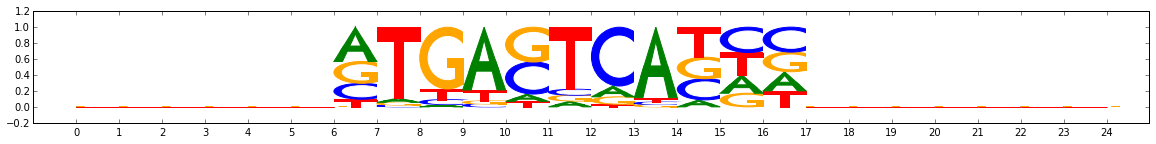

In [9]:
from matplotlib import pyplot as plt
#visualize the motif as a reminder
top_index = sorted(enumerate(max_nonzero_projection_scores),key=lambda x: -x[1])[0][0]
viz_sequence.plot_weights(motifs[top_index])

`nonzero_projection_scores[0,top_index,1]` has a 0 where the stronger match was to the fwd motif and a 1 where the
stronger match was to the reverse motif. We will print matches to the forward motif in blue, and matches to the reverse motif in green. Although TGA-TCA is palindromic, the motif above is slightly asymmetric (it is `-TGA-TCA---`), which is why the blue and green curves are slightly offset.


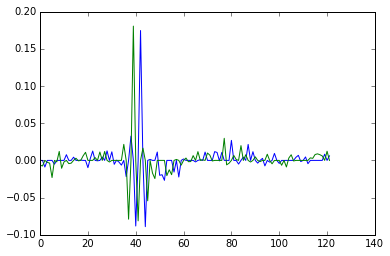

In [10]:
fwd_matches = nonzero_projection_scores[0,top_index,1]==0
rev_matches = nonzero_projection_scores[0,top_index,1]==1
plt.plot(nonzero_projection_scores[0,top_index,0]*fwd_matches)
plt.plot(nonzero_projection_scores[0,top_index,0]*rev_matches)